# trying with classes and shit

In [131]:
from random import *
from itertools import *
import numpy as np
from franke import FrankeFunction
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
%matplotlib inline

np.random.seed(69420666)

def create_data(points = 10000, noise = .01):
    
    x = np.random.random(size = points)
    y = np.random.random(size = points)
    #x = np.linspace(1, 10, points)
    #y = np.linspace(1, 10, points)
    z = FrankeFunction(x, y)
    
    #if noise:
     #   z_noise = z + np.random.normal(0, noise, size = z.shape[0])
    
    return x, y, z, noise

class Regression_methods(object):
    def __init__(self, A, y, lamb = 0):
        try:
            A.shape       
        except AttributeError:
            A = np.array(A)
        try:
            y.shape
        except AttributeError:
            y = np.array(y)
        if A.shape[0] != y.shape[0]:
            msg = 'Matrix and Vector must have compatable dimensions for matrix math'
            raise Exception(msg)
        
        self._A = A
        self._y = y
        self._lamb = lamb
        self._hessian = A.T @ A
    
    @property
    def beta(self):
        try:
            return self._beta
        except:
            if (self._lamb == 0 or self._lamb == None):
                self._beta = np.linalg.pinv(self._hessian) @ self._A.T @ self._y
                #u,s,v = np.linalg.svd(self._A)
                #c = np.dot(u.T,self._y)
                #w = np.linalg.solve(np.diag(s),c)
                #self._beta = np.dot(v.T,w)
                return self._beta
            
            else:
                n = self._hessian.shape[0]
                self._beta = np.linalg.inv(self._hessian + self._lamb*np.eye(n)) @ self._A.T @ self._y
                return self._beta
    
    @property
    def y_tilde(self):
        try:
            return self._y_tilde
        except:
            self._y_tilde = self._A @ self.beta
            return self._y_tilde
    
    
    @property
    def sigma_y(self):
        n = self._y.size
        p = self._hessian.shape[0]
        self._sigma_y = 1#/(n-p-1) * np.sum((self._y-self.y_tilde)**2)
        return self._sigma_y
    
    @property
    def beta_var(self):
        try:
            return self._beta_var
        except:
            self._beta_var = np.linalg.inv(self._hessian) * self.sigma_y
            return self._beta_var
    
    @property
    def hessian(self):
        return self._hessian
    
    def R2score(self):
        self.y_tilde
        return 1 - np.sum((self._y - self._y_tilde) ** 2) / np.sum((self._y - np.mean(self._y_tilde)) ** 2)

    def ms_error(self):
        self.y_tilde
        return np.sum((self._y-self._y_tilde)**2)/np.size(self._y_tilde)

    #def predict(self, X):
    #    return (X @ self.beta ).squeeze()
    

def no_resample_analysis(regression_object, method = 'ols', lamb = 0):
    
    if (method == 'ols'):
        betavar = np.diag(regression_object.beta_var)
        sigma = regression_object.sigma_y
    
    if (method == 'ridge'):
        sigma = regression_object.sigma_y
        x = regression_object.hessian
        W = np.linalg.inv(x+lamb*np.eye(x.shape[0]))@x
        betavar = np.diag(sigma*W@np.linalg.inv(x)@W.T)
           
    mse = regression_object.ms_error()
    r2 = regression_object.R2score()
    
    print('MSE: ', mse)
    print('R2 Score: ', r2)
    print('----Confidence Intervals for Selected Beta----')
    for i in range(len(betavar)):
        if i in np.arange(0,len(betavar)+1,2):
            print('$j={:}$ & {:.3} {} {:.3} \\'.format(i,regression_object.beta[i],r'$\pm$',2*betavar[i]))
    
    return betavar, sigma, mse, r2
    
def data_split(x_data, y_data, z_data, j):
    x_train=np.delete(x_data,j)
    y_train=np.delete(y_data,j)
    z_train=np.delete(z_data,j)
    x_test=np.take(x_data,j)
    y_test=np.take(y_data,j)
    z_test=np.take(z_data,j)
    
    return x_train, y_train, z_train, x_test, y_test, z_test       

        
def build_design_matrix(x1_data, x2_data, order):
    
    '''
    takes in sorted x and y data and creates a design matrix  of specified polynomial order
    x and y must be the same shape
    '''
    
    if x1_data.shape[0] != x2_data.shape[0]:
        msg = "\n\nArguments <x1> and <x2> in function <build_design_matrix> must be of "
        msg += f"the same shape."
        raise Exception(msg)
    
    if len(x1_data.shape) > 1:
        x1_data = np.ravel(x1_data)
        y1_data = np.ravel(y1_data)
        
    exponents = list(product(range(0,order+1), repeat=2)) #creates tupples of all combos from 0 to order
    expo_sum = np.sum(exponents, axis = 1) 
    valid_index = np.where(np.less_equal(expo_sum, order))[0] #collects index of sum(exponents) <= order
    exponents = np.array(exponents)
    exponents = exponents[valid_index] #only take in valid exponents
    
    design_matrix = np.zeros((x1_data.shape[0], exponents.shape[0]))
    for row in range(len(exponents)):
        for i in range(x1_data.shape[0]):
            design_matrix[i,row] = (x1_data[i]**exponents[row][0])*(x2_data[i]**exponents[row][1])
    return design_matrix        
        
def R2score(z, zhat):
    return 1 - np.sum((z - zhat) ** 2) / np.sum((z - np.mean(zhat)) ** 2)

def ms_error(z, zhat):
    return np.sum((z - zhat)**2)/np.size(zhat)

def bias(z,zhat):
    return np.mean((z - zhat)**2)
    
def my_kfold(xdata, ydata, zdata, model_type, lamb = 0, order = 5, k=5):
    '''
    take in x, y, z vectors from data set. 
    use model_type = 1 for OLS, =2 for Ridge, =3 for LASSO
    use poly_order to zet order of polynomial fit
    
    '''
    
    z_out = []
    x_out = []
    y_out = []
    
    error_test_local = 0
    error_train_local = 0
    r2_test_local = 0
    r2_train_local = 0
    
    error_global = 0
    bias_global = 0
    var_global = 0
    
    #matrix_cond = np.zeros(k)
    
    
    if (model_type == 'ols'):
        
        #q = int((order+1)*(order+2)/2)
        #beta_matrix = np.zeros((k,q)) # (k,number of poly terms) size matrix for beta
        
        xtr_global, xtst_global, ytr_global, ytst_global, ztr_global, ztst_global = train_test_split(xdata, ydata, zdata, test_size=0.2)
        
        ztr_global = ztr_global + np.random.normal(0, .1, size = ztr_global.shape[0])
        
        idx_vec = np.arange(len(xtr_global))
        L = int(len(idx_vec)/k)
        np.random.shuffle(idx_vec)
        
        Z = np.zeros((k, len(ztst_global)))
        
        for i in range(k):
            #print(idx_vec[i*L:(i+1)*L])
            x_train, y_train, z_train, xtst_local, ytst_local, ztst_local = data_split(xtr_global, ytr_global, ztr_global, idx_vec[i*L:(i+1)*L])
            
            d_train = build_design_matrix(x_train, y_train, order)
            d_tst_local = build_design_matrix(xtst_local, ytst_local, order)
            d_tst_global = build_design_matrix(xtst_global, ytst_global, order) 
            
            reg_object = Regression_methods(d_train, z_train, lamb = lamb)
            beta = reg_object.beta
            
            #beta_matrix [i] = beta
            #matrix_cond[i] = np.linalg.cond(design_test)
            
            z_pred_train = d_train @ beta
            
            z_pred_local = d_tst_local @ beta
            
            Z[i] = d_tst_global @ beta
            
            #train / test error scores
            error_test_local += ms_error(ztst_local, z_pred_local)
            error_train_local += ms_error(z_train, z_pred_train)
            r2_test_local += R2score(ztst_local, z_pred_local)
            r2_train_local += R2score(z_train, z_pred_train)
                      
            z_out = np.concatenate((z_out, z_pred_local), axis = 0)
            x_out = np.concatenate((x_out, xtst_local), axis = 0)
            y_out = np.concatenate((y_out, ytst_local), axis = 0)
            
        error_global = ms_error(ztst_global, np.mean(Z,axis=0))
        bias_global = bias(ztst_global, np.mean(Z,axis=0))
        var_global = np.mean(np.var(Z,axis=0))
        
        data = np.zeros((z_out.size,3))
        data[:,0] = x_out
        data[:,1] = y_out
        data[:,2] = z_out
         
        #print('{} >= {} + {} = {}'.format(MSE_, bias_, variance_, bias_+variance_))
       
        return data, error_test_local/k, error_train_local/k, r2_test_local/k, r2_train_local/k, error_global, bias_global, var_global
    


def bias_variance(xdata, ydata, zdata, model_type, lamb = 0, poly_order = 5, k=5):
    '''
    This function performs a regression analysis specified by:
            
            model_type: 'ols', 'ridge', 'lasso'
    
    While doing k = 5 kfold cross validation resampling
    This is done for polynomial fits from:
    
            polynomial order = 1 to poly_order
    
    The bias variance tradeoff is then plotted vs polynomial order
    '''
    vec_size = poly_order + 1
    polynomial_vec = np.arange(vec_size)
    
    
    
    error_test = np.zeros(vec_size)
    error_train = np.zeros(vec_size)
    r2vec = np.zeros(vec_size)
    
    error_global = np.zeros(vec_size)
    bias_ = np.zeros(vec_size)
    variance = np.zeros(vec_size)
    
    for i in polynomial_vec:
        data_out, error_test_, error_train_, r2, _, error_global_, biasval, varianceval = my_kfold(xdata, ydata, zdata, 'ols', lamb = 0, order = i, k=5)        
        
        error_test[i] = error_test_
        error_train[i] = error_train_
        r2vec[i] = r2
        
        error_global[i] = error_global_
        bias_[i] = biasval
        variance[i] = varianceval
        
        print("polynomial degree: ", i)
        print('R2 test is: ', r2vec[i])
        print('Error test is: ', error_test[i])
        print('-------------------------------')
        print('Global error is: ', error_global[i])
        print("bias is: ", bias_[i])
        print("variance is: ", variance[i])
        print('{} >= {} + {} = {}'.format(error_global[i], bias_[i], variance[i], bias_[i] + variance[i]))
        #print("Matrix condition number is: ", '{0:1.2e}'.format(condition[i]))
               
        fig1 = plt.figure(1)
        #xplot = np.reshape(data_out[:,0],(x_size,x_size))
        #yplot = np.reshape(data_out[:,1],(x_size,x_size))
        #zplot = np.reshape(data_out[:,2],(x_size,x_size))
        
        plt.scatter(data_out[:,0],data_out[:,1],c=data_out[:,2], cmap=cm.plasma)
        plt.show()
    
    fig2 = plt.figure(2)
    plt.semilogy(polynomial_vec, error_global, label='Error')
    #plt.set_xlim([xmin,xmax])
    #plt.axis([0,12,1,2])
    #plt.semilogy(polynomial_vec, bias_, label='bias')
    plt.semilogy(polynomial_vec, variance, label='Variance')
    #plt.semilogy(polynomial_vec, variance+bias_, label='Variance + bias')
    plt.legend()
    plt.show()
    
    fig2 = plt.figure(3)
    plt.semilogy(polynomial_vec, error_test, label='Error_test')
    #plt.set_xlim([xmin,xmax])
    #plt.axis([0,12,1,2])
    plt.semilogy(polynomial_vec, error_train, label='Error_train')
    plt.legend()
    plt.show()
     
        
    return 0
                


# 1a

In [132]:
x_array, y_array, z_array, _ = create_data(points = 1000, noise = .5)


A = build_design_matrix(x_array, y_array, 5)

ols_object = Regression_methods(A, z_array, lamb = 0)

test = no_resample_analysis(ols_object, method = 'ols', lamb = 0)


MSE:  0.002128683606192637
R2 Score:  0.9744636781396987
----Confidence Intervals for Selected Beta----
$j=0$ & 0.409 $\pm$ 0.453 \
$j=2$ & -10.1 $\pm$ 1.52e+03 \
$j=4$ & 25.7 $\pm$ 9.09e+03 \
$j=6$ & 7.6 $\pm$ 58.7 \
$j=8$ & 19.0 $\pm$ 4.08e+03 \
$j=10$ & 17.0 $\pm$ 1.02e+03 \
$j=12$ & 42.4 $\pm$ 4.28e+03 \
$j=14$ & -6.69 $\pm$ 9.5e+02 \
$j=16$ & -53.0 $\pm$ 5.07e+03 \
$j=18$ & -23.1 $\pm$ 8.95e+03 \
$j=20$ & 1.17 $\pm$ 1.42e+03 \


# 1b

polynomial degree:  0
R2 test is:  -2.2204460492503132e-17
Error test is:  0.0917310556462262
-------------------------------
Global error is:  0.08316482460067716
bias is:  0.08316482460067716
variance is:  7.601807118200637e-06
0.08316482460067716 >= 0.08316482460067716 + 7.601807118200637e-06 = 0.08317242640779536


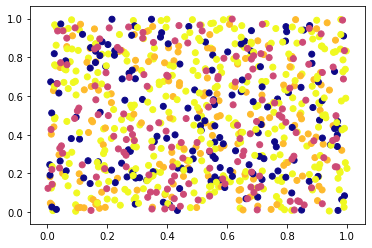

polynomial degree:  1
R2 test is:  0.6356738913692389
Error test is:  0.03421810006933681
-------------------------------
Global error is:  0.021287995813051245
bias is:  0.021287995813051245
variance is:  2.1956476704389936e-05
0.021287995813051245 >= 0.021287995813051245 + 2.1956476704389936e-05 = 0.021309952289755636


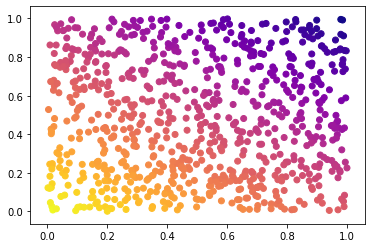

polynomial degree:  2
R2 test is:  0.7053262141154726
Error test is:  0.027862692357004205
-------------------------------
Global error is:  0.017735916820711094
bias is:  0.017735916820711094
variance is:  2.5158979523149202e-05
0.017735916820711094 >= 0.017735916820711094 + 2.5158979523149202e-05 = 0.017761075800234245


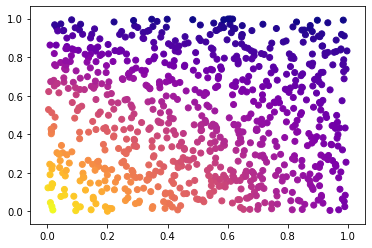

polynomial degree:  3
R2 test is:  0.7964195343969331
Error test is:  0.017745237743230786
-------------------------------
Global error is:  0.010221410342967217
bias is:  0.010221410342967217
variance is:  7.80780725606592e-05
0.010221410342967217 >= 0.010221410342967217 + 7.80780725606592e-05 = 0.010299488415527877


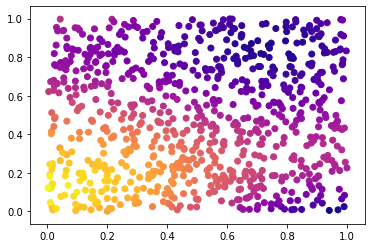

polynomial degree:  4
R2 test is:  0.8396100819277634
Error test is:  0.014849123061220368
-------------------------------
Global error is:  0.0035854045952368662
bias is:  0.0035854045952368662
variance is:  7.468728656498595e-05
0.0035854045952368662 >= 0.0035854045952368662 + 7.468728656498595e-05 = 0.0036600918818018523


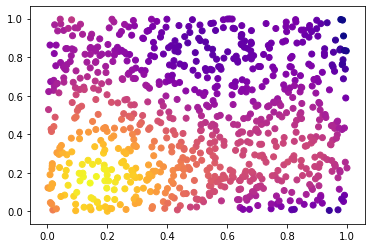

polynomial degree:  5
R2 test is:  0.8660728517598265
Error test is:  0.012433661767296062
-------------------------------
Global error is:  0.002760616698447708
bias is:  0.002760616698447708
variance is:  0.0001013469191362032
0.002760616698447708 >= 0.002760616698447708 + 0.0001013469191362032 = 0.0028619636175839114


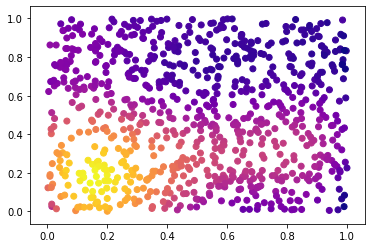

polynomial degree:  6
R2 test is:  0.8819455333731516
Error test is:  0.010717910026589053
-------------------------------
Global error is:  0.0014605053280333168
bias is:  0.0014605053280333168
variance is:  0.0001392316806693819
0.0014605053280333168 >= 0.0014605053280333168 + 0.0001392316806693819 = 0.0015997370087026987


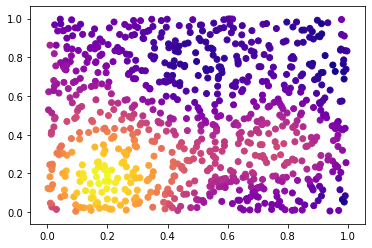

polynomial degree:  7
R2 test is:  0.8644201696980041
Error test is:  0.012106033419133704
-------------------------------
Global error is:  0.0007799718613333929
bias is:  0.0007799718613333929
variance is:  0.00030354756147607726
0.0007799718613333929 >= 0.0007799718613333929 + 0.00030354756147607726 = 0.0010835194228094702


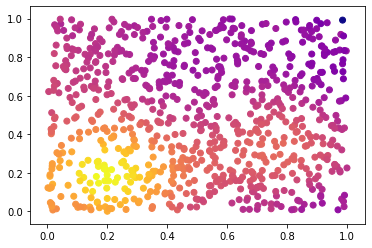

polynomial degree:  8
R2 test is:  0.8842430795961217
Error test is:  0.010617539714358004
-------------------------------
Global error is:  0.0016104645625812316
bias is:  0.0016104645625812316
variance is:  0.00029826394602504454
0.0016104645625812316 >= 0.0016104645625812316 + 0.00029826394602504454 = 0.0019087285086062762


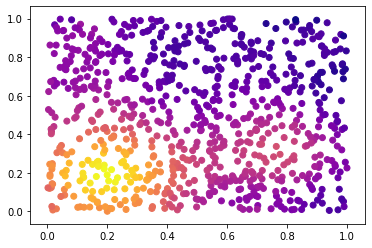

polynomial degree:  9
R2 test is:  0.8853535211010615
Error test is:  0.010623816016247714
-------------------------------
Global error is:  0.0009961992414903595
bias is:  0.0009961992414903595
variance is:  0.0002119128652027615
0.0009961992414903595 >= 0.0009961992414903595 + 0.0002119128652027615 = 0.001208112106693121


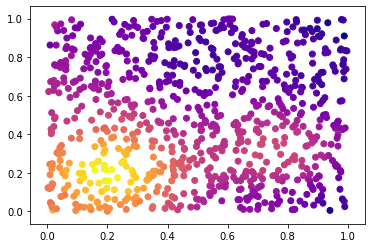

polynomial degree:  10
R2 test is:  0.8781359573627094
Error test is:  0.010813035655081992
-------------------------------
Global error is:  0.0011082657178498356
bias is:  0.0011082657178498356
variance is:  0.00027623326794700727
0.0011082657178498356 >= 0.0011082657178498356 + 0.00027623326794700727 = 0.0013844989857968429


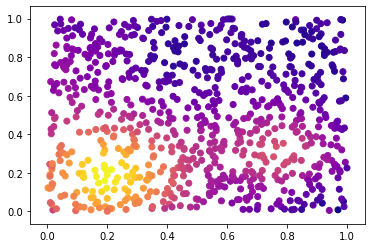

polynomial degree:  11
R2 test is:  0.871046290090572
Error test is:  0.012437722527673011
-------------------------------
Global error is:  0.0009273512494025081
bias is:  0.0009273512494025081
variance is:  0.00041241115684282557
0.0009273512494025081 >= 0.0009273512494025081 + 0.00041241115684282557 = 0.0013397624062453336


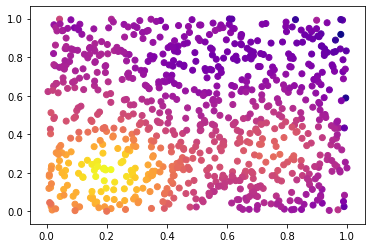

polynomial degree:  12
R2 test is:  0.8602751952471346
Error test is:  0.012636846777609137
-------------------------------
Global error is:  0.001786766632782673
bias is:  0.001786766632782673
variance is:  0.000481619058850477
0.001786766632782673 >= 0.001786766632782673 + 0.000481619058850477 = 0.00226838569163315


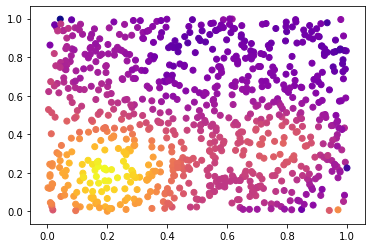

polynomial degree:  13
R2 test is:  0.8641866246226538
Error test is:  0.011809562527129062
-------------------------------
Global error is:  0.0007200766072619941
bias is:  0.0007200766072619941
variance is:  0.00026682950671069765
0.0007200766072619941 >= 0.0007200766072619941 + 0.00026682950671069765 = 0.0009869061139726918


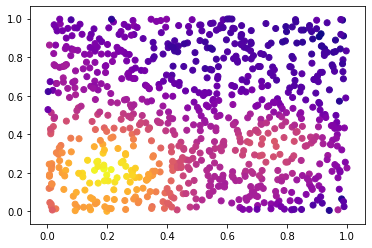

polynomial degree:  14
R2 test is:  0.8691049103076208
Error test is:  0.012265285912443632
-------------------------------
Global error is:  0.0009414572027534558
bias is:  0.0009414572027534558
variance is:  0.0006562870451946456
0.0009414572027534558 >= 0.0009414572027534558 + 0.0006562870451946456 = 0.0015977442479481014


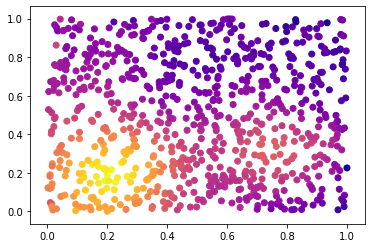

polynomial degree:  15
R2 test is:  0.8672993858091583
Error test is:  0.012698141804803642
-------------------------------
Global error is:  0.005043700160480946
bias is:  0.005043700160480946
variance is:  0.0014407298568350027
0.005043700160480946 >= 0.005043700160480946 + 0.0014407298568350027 = 0.006484430017315948


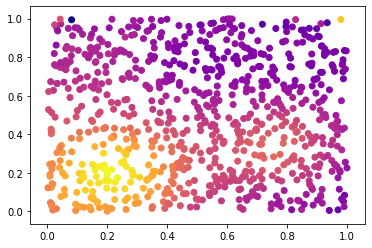

polynomial degree:  16
R2 test is:  0.8026997309298874
Error test is:  0.01894768919404583
-------------------------------
Global error is:  0.0025168125185435087
bias is:  0.0025168125185435087
variance is:  0.0026471745574674407
0.0025168125185435087 >= 0.0025168125185435087 + 0.0026471745574674407 = 0.005163987076010949


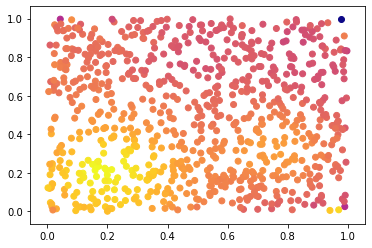

polynomial degree:  17
R2 test is:  0.8601596212437492
Error test is:  0.012811121077446691
-------------------------------
Global error is:  0.001677034056526115
bias is:  0.001677034056526115
variance is:  0.0010781306555343697
0.001677034056526115 >= 0.001677034056526115 + 0.0010781306555343697 = 0.0027551647120604844


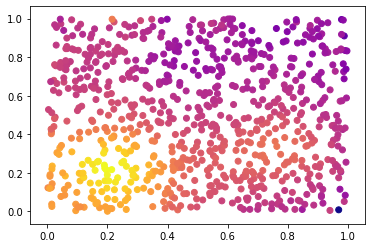

polynomial degree:  18
R2 test is:  0.8495431256060144
Error test is:  0.014566080138771786
-------------------------------
Global error is:  0.004270291667561472
bias is:  0.004270291667561472
variance is:  0.004200149328018945
0.004270291667561472 >= 0.004270291667561472 + 0.004200149328018945 = 0.008470440995580416


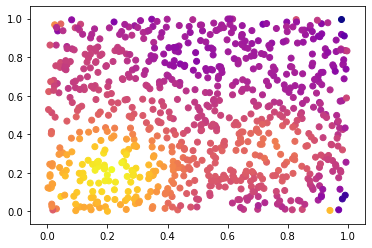

polynomial degree:  19
R2 test is:  0.7723131221420875
Error test is:  0.021917800817745504
-------------------------------
Global error is:  0.005830458647683425
bias is:  0.005830458647683425
variance is:  0.0018981406660137426
0.005830458647683425 >= 0.005830458647683425 + 0.0018981406660137426 = 0.007728599313697168


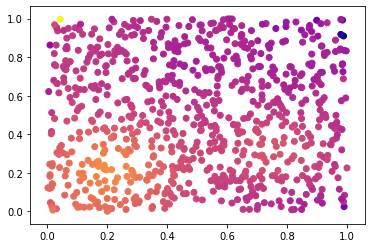

polynomial degree:  20
R2 test is:  0.8438652266621551
Error test is:  0.014089723955273947
-------------------------------
Global error is:  0.04439487136289943
bias is:  0.04439487136289943
variance is:  0.11935360665990494
0.04439487136289943 >= 0.04439487136289943 + 0.11935360665990494 = 0.16374847802280437


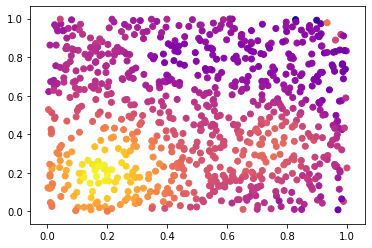

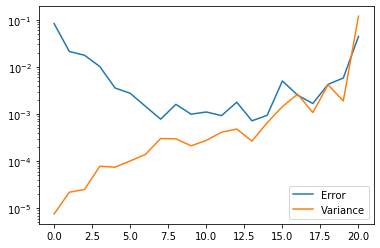

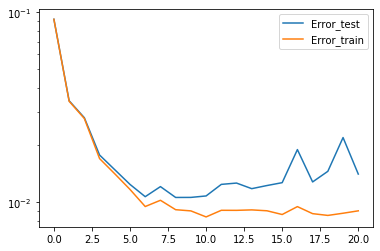

0

In [133]:
#k fold for ols

#values,a,b,c,d,_,_ = my_kfold(x_array, y_array, z_array, 'ols', lamb = 0, order = 0, k=5)
#print('error test: ', a)
#print('error train: ', b)
#print('r2 test: ', c)
#print('r2 train: ', d)

bias_variance(x_array, y_array, z_array, 'ols', lamb = 0, poly_order = 20, k=5)

# ridge

In [41]:
A = build_design_matrix(x_array, y_array, 5)

ridge_object = Regression_methods(A, z_array, lamb = 10000)

test = no_resample_analysis(ols_object, method = 'ridge', lamb = 10000)

MSE:  0.002041585095522354
R2 Score:  0.975222039406892
----Confidence Intervals for Selected Beta----
$j=0$ & 0.38 $\pm$ 3.15e-05 \
$j=2$ & -9.02 $\pm$ 7.89e-06 \
$j=4$ & 28.4 $\pm$ 6.36e-06 \
$j=6$ & 8.08 $\pm$ 1.01e-05 \
$j=8$ & 20.3 $\pm$ 2.96e-06 \
$j=10$ & 17.0 $\pm$ 2.37e-06 \
$j=12$ & 45.6 $\pm$ 3e-06 \
$j=14$ & -5.82 $\pm$ 1.94e-06 \
$j=16$ & -55.4 $\pm$ 2.67e-06 \
$j=18$ & -25.3 $\pm$ 6.51e-06 \
$j=20$ & 1.9 $\pm$ 6.13e-06 \


In [43]:
bias_variance(x_array, y_array, z_array, 'ols', lamb = 0.1, poly_order = 10, k=5)

polynomial degree:  0
R2 test is:  -4.4408920985006264e-17
Error test is:  0.08183991411214635
-------------------------------
Global error is:  0.08468600507245484
bias is:  0.08468600507245486
variance is:  2.1570415377137042e-32
0.08468600507245484 >= 0.08468600507245486 + 2.1570415377137042e-32 = 0.08468600507245486
polynomial degree:  1
R2 test is:  0.7178075802641514
Error test is:  0.023164517034649598
-------------------------------
Global error is:  0.02363389824544271
bias is:  0.08366353863015653
variance is:  0.05979541184988467
0.02363389824544271 >= 0.08366353863015653 + 0.05979541184988467 = 0.1434589504800412
polynomial degree:  2
R2 test is:  0.7918794107404212
Error test is:  0.017028023238931433
-------------------------------
Global error is:  0.016854319691073875
bias is:  0.08463771759872248
variance is:  0.06396266141014749
0.016854319691073875 >= 0.08463771759872248 + 0.06396266141014749 = 0.14860037900886996
polynomial degree:  3
R2 test is:  0.9051191454547522

0